In [114]:
pip install torchvision

In [115]:
pip install opendatasets

In [116]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json 
!ls ~/.kaggle

kaggle.json


In [117]:
from torchvision import models
import torch
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

import opendatasets as od
import pathlib
import matplotlib.pyplot as plt

In [118]:
od.download('https://www.kaggle.com/puneet6060/intel-image-classification')

Skipping, found downloaded files in "./intel-image-classification" (use force=True to force download)


In [119]:
# Data transforms (normalization & data augmentation)

stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
img_size = 128
train_tfms = tt.Compose([tt.Resize((img_size,img_size)),
                         tt.RandomCrop(img_size, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(),                         
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.Resize((img_size, img_size)), tt.ToTensor(), tt.Normalize(*stats)])
#data_dir = pathlib.Path('/content/intel-image-classification')
# PyTorch datasets
train_ds = ImageFolder('/content/intel-image-classification'+'/seg_train/seg_train', train_tfms)
valid_ds = ImageFolder('/content/intel-image-classification'+'/seg_test/seg_test', valid_tfms)

batch_size = 128

# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [120]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
       

In [121]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        images, labels = images.to(device),labels.to(device)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        images, labels = images.to(device),labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))
            
 # --------------------------------------------------------------------------#
 
from torchvision import models

class MyModel(ImageClassificationBase):
    def __init__(self, num_classes , pretrained=True):
        super().__init__()

        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)
        
    def forward(self, xb):
        return self.network(xb)

In [122]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


# def fit(epochs, lr, model, train_loader, val_loader):
#    # opt_func=torch.optim.Adam(model.parameters(), lr=0.001)
#     history = []
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [123]:
obj = ImageClassificationBase()

In [124]:
alexnet = models.alexnet(pretrained=True)

In [125]:
device  = get_default_device()
#train_dl = to_device(train_dl,device)
DeviceDataLoader(train_dl,device)

In [126]:
mymodel = MyModel(6)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mymodel.to(device)

In [128]:
epochs = 5
lr = 0.01

In [129]:
history1 = fit(epochs,lr,mymodel,train_dl,valid_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [0], train_loss: 0.4896, val_loss: 0.2659, val_acc: 0.9099



Epoch [1], train_loss: 0.2332, val_loss: 0.2266, val_acc: 0.9212



Epoch [2], train_loss: 0.1890, val_loss: 0.2111, val_acc: 0.9250



Epoch [3], train_loss: 0.1604, val_loss: 0.2072, val_acc: 0.9268



Epoch [4], train_loss: 0.1368, val_loss: 0.1990, val_acc: 0.9273


In [130]:
print(history1)

[{'val_loss': 0.2659284770488739, 'val_acc': 0.9098590016365051, 'train_loss': 0.4896456003189087}, {'val_loss': 0.22655698657035828, 'val_acc': 0.9211814999580383, 'train_loss': 0.2332276701927185}, {'val_loss': 0.21111297607421875, 'val_acc': 0.9250169396400452, 'train_loss': 0.1889651119709015}, {'val_loss': 0.2071855068206787, 'val_acc': 0.9268426895141602, 'train_loss': 0.16038218140602112}, {'val_loss': 0.19902750849723816, 'val_acc': 0.9272956252098083, 'train_loss': 0.13677409291267395}]


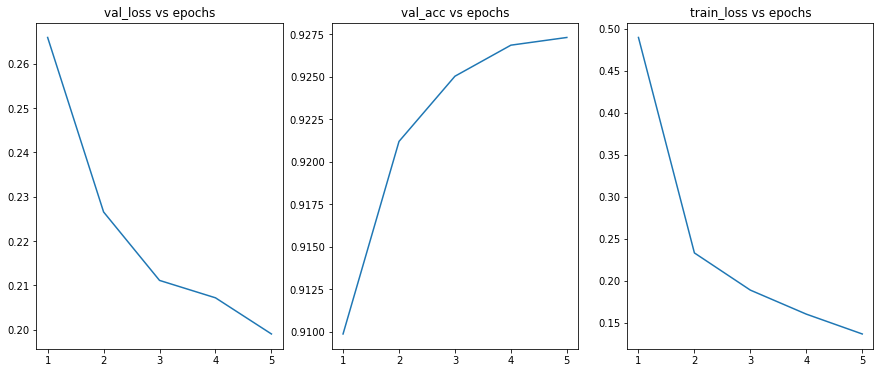

In [131]:
li1 = []
li2 = []
li3 = []
for dict1 in history1:
    li1.append(dict1["val_loss"])
    li2.append(dict1["val_acc"])
    li3.append(dict1["train_loss"])

fig =plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.plot(range(1,epochs+1), li1)
plt.title("val_loss vs epochs")

plt.subplot(1, 3, 2)
plt.plot(range(1,epochs+1), li2)
plt.title("val_acc vs epochs")

plt.subplot(1, 3, 3)
plt.plot(range(1,epochs+1), li3)
plt.title("train_loss vs epochs")

plt.show()

In [137]:
epoch2 = 3
lr = 0.01

In [138]:
history2 = fit_one_cycle(epoch2,lr,mymodel,train_dl,valid_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [0],last_lr: 0.00994, train_loss: 0.0493, val_loss: 0.2735, val_acc: 0.9230



Epoch [1],last_lr: 0.00463, train_loss: 0.0568, val_loss: 0.2396, val_acc: 0.9275



Epoch [2],last_lr: 0.00000, train_loss: 0.0314, val_loss: 0.2245, val_acc: 0.9369


In [139]:
print(history2)

[{'val_loss': 0.2734905481338501, 'val_acc': 0.9230072498321533, 'train_loss': 0.049297597259283066, 'lrs': [0.0003999999999999993, 0.00040246616223669693, 0.00040986211479838476, 0.00042218025784384813, 0.0004394079336484183, 0.0004615274396106376, 0.0004885160464428856, 0.0005203460215272467, 0.0005569846574126572, 0.0005983943054240284, 0.0006445324143487894, 0.0006953515741611495, 0.0007507995647390957, 0.0008108194095240995, 0.0008753494340683881, 0.0009443233294095989, 0.0010176702202077306, 0.0010953147375743367, 0.0011771770965191657, 0.0012631731779346109, 0.001353214615033807, 0.0014472088841534555, 0.0015450593998281546, 0.0016466656140384853, 0.0017519231195309067, 0.0018607237571032637, 0.0019729557267456795, 0.002088503702522615, 0.0022072489510780785, 0.0023290694536421625, 0.002453840031413585, 0.0025814324741893664, 0.0027117156721094783, 0.002844555750381097, 0.0029798162068439896, 0.0031173580522357207, 0.00325703995301251, 0.0033987183765790034, 0.003542247738777723

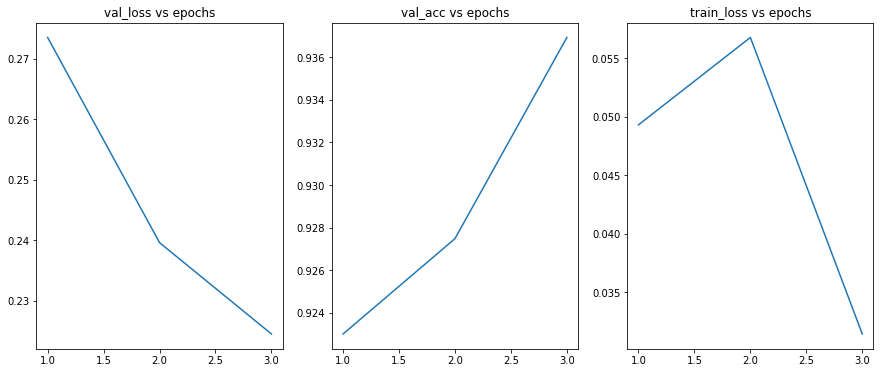

In [140]:
li1 = []
li2 = []
li3 = []
for dict1 in history2:
    li1.append(dict1["val_loss"])
    li2.append(dict1["val_acc"])
    li3.append(dict1["train_loss"])

fig =plt.figure(figsize=(15, 6))


plt.subplot(1, 3, 1)
plt.plot(range(1,epoch2+1), li1)
plt.title("val_loss vs epochs")

plt.subplot(1, 3, 2)
plt.plot(range(1,epoch2+1), li2)
plt.title("val_acc vs epochs")


plt.subplot(1, 3, 3)
plt.plot(range(1,epoch2+1), li3)
plt.title("train_loss vs epochs")

plt.show()